# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [149]:
# importing necessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.cluster import KMeans, MiniBatchKMeans
import lightgbm as lgb



# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [75]:
print('Loading Azdias Dataset')
# load in the data
azdias = pd.read_csv('./Azdias.csv').drop(['Unnamed: 0'], axis=1) # General demographics data


Loading Azdias Dataset


E:\Program_Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Load files which explain features of above data
attributes = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx').drop(['Unnamed: 0'], axis=1).T.set_index(0).T
attr_vals = pd.read_excel('./DIAS Attributes - Values 2017.xlsx').drop(['Unnamed: 0'], axis=1).T.set_index(0).T

In [4]:
# Check the structure of the data after it's loaded
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# Checking attribute details
display(attributes.shape)
display(attributes.head())

attr_vals['Attribute'].ffill(inplace=True)
attr_vals['Description'].ffill(inplace=True)

display(attr_vals.shape)
display(attr_vals.head())


(313, 4)

,Information level,Attribute,Description,Additional notes
1,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
2,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,NaN,ANREDE_KZ,gender,NaN
4,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
5,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


(2258, 4)

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,best-ager typology,0,no classification possible
3,AGER_TYP,best-ager typology,1,passive elderly
4,AGER_TYP,best-ager typology,2,cultural elderly
5,AGER_TYP,best-ager typology,3,experience-driven elderly


In [6]:
azdias.shape

(891221, 366)

The number of columns in General population dataframe is 366  
We have the data of a total of 891221 people 

In [7]:
# Examining the features of the data
display(azdias.info())
azdias.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


None

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486465,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,817722.0,7.908791,1.923137,1.0,8.0,9.0,9.0,9.0
WOHNLAGE,798073.0,4.052836,1.949539,0.0,3.0,3.0,5.0,8.0
ZABEOTYP,891221.0,3.362438,1.352704,1.0,3.0,3.0,4.0,6.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Step 1: Preprocessing  
  
    
### Step 1.1: Remove errors in data
There are certain errors in the data, this was seen while loading the data files. Removing the errors by either correcting the mostake or removing the part of data is crucial



There was a certain error while loading the data, in columns 19 and 20  
Let's examine these columns

In [8]:
print(azdias.iloc[:,19:21].columns)

Index(['CAMEO_INTL_2015', 'CJT_GESAMTTYP'], dtype='object')


In [9]:
display(azdias.CAMEO_DEUG_2015.unique())

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

Due to errors in the data, there are values like 'X' and 'XX' where there should just be NaN  
Here we shall correct this error and change the datatype to float

In [10]:
cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
azdias[cols] = azdias[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
azdias[cols] = azdias[cols].astype(float)


In [11]:
display(azdias.CAMEO_DEUG_2015.unique())


array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

### Step 1.2: Assess Missing Data  
The Attributes file contains a summary of properties for each demographics data column which we shall use to help make cleaning decisions during this stage of the project. Firstly, we assess the demographics data in terms of missing data.
  
Analyzing the data for missing values next is essential

In [12]:
#Chhecking for duplicate data
azdias.duplicated().sum()

0

In [13]:
#Checking for distribution of missing values
missing = (azdias.isnull().mean()).sort_values(ascending=False)

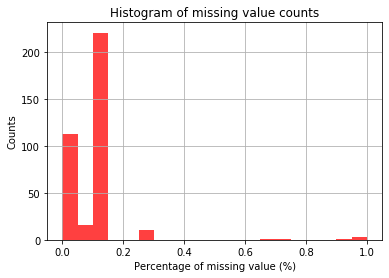

In [17]:
plt.hist(missing, bins=20, facecolor='r', alpha=0.75)


plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts')
plt.grid(True)
plt.show()


### Step 1.3: Drop Columns
A number of columns are unable to contribute effectively to the analysis due to numerous reasons ranging from the absence of Column name in Attributes file to presence of a high percentage of missing values

There are certain columns present in the Azdias Data which are not explained in the Attributes file.  
Since we do not have information about these columns, we cannot use them to analyse the data, and hence they shall be dropped

In [18]:
dif = set(azdias.columns.values).difference(set(attr_vals['Attribute']))
display("Number of columns in original dataframe", len(azdias.columns.values))
display("Number of Attributes in Attributes Dataframe with description", len(set(attr_vals['Attribute'])))
display("Number of Columns to remove", len(dif))
az_rmv = azdias[list(dif)]
azdias.drop(dif, axis = 1, inplace = True)




'Number of columns in original dataframe'

366

'Number of Attributes in Attributes Dataframe with description'

314

'Number of Columns to remove'

94

In [19]:
# The columns that were removed from the data
az_rmv

,D19_BEKLEIDUNG_GEH,EINGEZOGENAM_HH_JAHR,KONSUMZELLE,CJT_TYP_4,D19_WEIN_FEINKOST,KBA13_ANTG2,D19_VOLLSORTIMENT,D19_BANKEN_LOKAL,ALTERSKATEGORIE_FEIN,UMFELD_JUNG,...,KK_KUNDENTYP,D19_KOSMETIK,D19_REISEN,D19_KONSUMTYP_MAX,D19_SONSTIGE,VHA,ALTER_KIND4,VK_DISTANZ,VK_ZG11,ANZ_KINDER
0,0,NaN,NaN,5.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0,9,0,NaN,NaN,NaN,NaN,NaN
1,0,2004.0,1.0,3.0,0,4.0,0,0,21.0,3.0,...,NaN,0,0,9,0,0.0,NaN,11.0,10.0,0.0
2,0,2000.0,0.0,3.0,0,3.0,7,0,17.0,5.0,...,NaN,6,0,8,6,0.0,NaN,9.0,6.0,0.0
3,0,1998.0,0.0,4.0,0,3.0,0,0,13.0,5.0,...,NaN,0,6,8,6,1.0,NaN,10.0,11.0,0.0
4,6,2004.0,0.0,4.0,0,4.0,0,0,14.0,3.0,...,1.0,0,0,1,4,0.0,NaN,5.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0,2014.0,0.0,3.0,0,3.0,6,0,17.0,1.0,...,3.0,0,0,2,0,0.0,NaN,7.0,8.0,0.0
891217,0,1999.0,1.0,3.0,0,4.0,0,0,16.0,2.0,...,NaN,0,0,8,7,0.0,NaN,9.0,6.0,0.0
891218,5,2013.0,0.0,1.0,0,2.0,0,0,17.0,5.0,...,NaN,6,0,2,5,0.0,NaN,10.0,8.0,0.0
891219,0,1998.0,0.0,2.0,0,3.0,0,0,20.0,4.0,...,NaN,0,6,8,6,0.0,NaN,8.0,5.0,1.0


Adding a column to keep record of null values per row

D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MAXHERST                 0.149597
                                 ...   
FINANZ_SPARER                  0.000000
FINANZ_MINIMALIST              0.000000
FINANZ_HAUSBAUER               0.000000
FINANZ_ANLEGER                 0.000000
AGER_TYP                       0.000000
Length: 272, dtype: float64

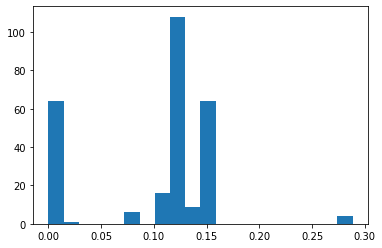

In [21]:
plt.hist(azdias.isnull().mean(), bins = 20)
azdias.isnull().mean().sort_values(ascending= False)

In [22]:
azdias['na_val']= azdias.isnull().sum(axis=1)
azdias

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,na_val
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,-1,NaN,-1,NaN,NaN,NaN,3,1,2,207
1,-1,0.0,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,...,3,0.0,2,3.0,9.0,4.0,5,2,1,4
2,-1,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,...,2,0.0,1,3.0,9.0,2.0,5,2,3,0
3,2,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,...,1,0.0,1,NaN,9.0,7.0,3,2,4,1
4,-1,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,...,2,0.0,2,2.0,9.0,3.0,4,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,17.0,15.0,0.0,1.0,0.0,6.0,7A,7.0,5.0,...,3,0.0,1,3.0,4.0,3.0,4,2,3,2
891217,-1,16.0,11.0,0.0,1.0,0.0,7.0,9D,9.0,4.0,...,-1,0.0,-1,6.0,9.0,5.0,6,1,2,0
891218,-1,17.0,3.0,0.0,0.0,0.0,5.0,4C,4.0,4.0,...,2,0.0,1,NaN,5.0,7.0,4,2,2,1
891219,-1,0.0,7.0,0.0,1.0,0.0,2.0,9D,9.0,3.0,...,0,0.0,2,1.0,9.0,5.0,5,1,1,0


Assess the percentage of rows with high number of missing values and remove rows with na_val above a certain threshold(150).

In [23]:
sz= azdias.shape
azdias.drop(azdias.loc[azdias['na_val']>150].index, inplace = True)
(sz[0]-azdias.shape[0])*100/sz[0]

11.13461195371294

We have removed 11.13% of the data.


(array([7.43019e+05, 7.50700e+03, 8.03000e+02, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.57240e+04, 7.83100e+03, 5.30000e+02, 5.00000e+00, 0.00000e+00,
        0.00000e+00, 3.78000e+02, 3.36200e+03, 2.78600e+03, 4.00000e+01]),
 array([  0. ,   6.4,  12.8,  19.2,  25.6,  32. ,  38.4,  44.8,  51.2,
         57.6,  64. ,  70.4,  76.8,  83.2,  89.6,  96. , 102.4, 108.8,
        115.2, 121.6, 128. ]),
 <a list of 20 Patch objects>)

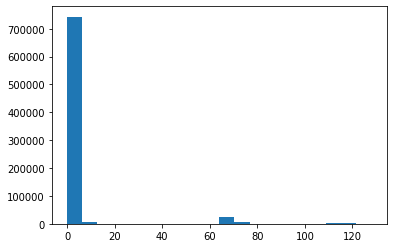

In [24]:
plt.hist(azdias.na_val, bins = 20)

### Step 1.4: Convert Missing Value Codes to NaNs¶
A column of the attributes summary (loaded in above as attr_vals) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. [-1,0]), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [25]:
attr_vals[(attr_vals['Meaning'].str.contains("unknown") | attr_vals['Meaning'].str.contains("no "))][['Value', 'Attribute']]


,Value,Attribute
1,-1,AGER_TYP
2,0,AGER_TYP
6,"-1, 0",ALTERSKATEGORIE_GROB
12,0,ALTER_HH
34,"-1, 0",ANREDE_KZ
...,...,...
2230,-1,WOHNLAGE
2231,0,WOHNLAGE
2239,"-1, 0",WACHSTUMSGEBIET_NB
2245,"-1, 0",W_KEIT_KIND_HH


In [26]:
attr_vals[attr_vals['Value'].str.contains(',', na= False)]


,Attribute,Description,Value,Meaning
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
34,ANREDE_KZ,gender,"-1, 0",unknown
698,GEBAEUDETYP,type of building (residential or commercial),"-1, 0",unknown
725,GEOSCORE_KLS7,microgeographical risk index concerning popula...,"-1, 0",unknown
735,HAUSHALTSSTRUKTUR,"structure of the household (single-hh, couple ...","-1, 0",unknown
...,...,...,...,...
2211,TITEL_KZ,flag whether this person holds an academic title,"-1, 0",unknown
2220,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2239,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2245,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


Seperating Values from List type of Unknows or Missing values to int type

In [27]:
dbl= attr_vals[attr_vals['Value'].str.contains(',', na= False)]['Value'].str.split(', ', expand= True)
# attr_vals[attr_vals['Value'].str.contains(',', na= False)]['Value'].str.split(', ', expand= True)
tmp = pd.DataFrame({'Attribute':[], 'Description': [], 'Value': [], 'Meaning': []})
for i in dbl.index:
    atbt = [attr_vals['Attribute'][i]]
    dsc = [attr_vals['Description'][i]]
    mng = [attr_vals['Meaning'][i]]
    row1 = pd.DataFrame({'Attribute':atbt, 'Description':dsc, 'Value': [dbl[0][i]] , 'Meaning':mng})
    tmp = pd.concat([row1, tmp], ignore_index=True)
    row2 = pd.DataFrame({'Attribute':atbt, 'Description':dsc, 'Value': [dbl[1][i]] , 'Meaning':mng})
    tmp = pd.concat([row2, tmp], ignore_index=True)
tem = pd.concat([attr_vals, tmp], ignore_index=True).sort_values(['Attribute', 'Value']).reset_index().drop('index', axis = 1)
tem.drop(tem[tem['Value'].str.contains(',', na= False)].index, inplace= True)
tem.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2434,ZABEOTYP,typification of energy consumers,4,price driven
2435,ZABEOTYP,typification of energy consumers,5,seeking orientation
2436,ZABEOTYP,typification of energy consumers,6,indifferent
2437,ZABEOTYP,typification of energy consumers,-1,unknown


Putting in NaN value in place of every NaN component

In [31]:
na_val= tem[(tem['Meaning'].str.contains("unknown") | tem['Meaning'].str.contains("no "))][['Value', 'Attribute']]
na_val = na_val.reset_index().groupby('Attribute')['Value'].apply(list)
p=0
for col,val in zip(na_val.index, na_val.values):
    if(col in azdias.columns):
        azdias.loc[azdias[col].isin(val),col]= np.nan
        p+=1
        print(p, 'of ',250, 'done!')

display(azdias)


1 of  250 done!
2 of  250 done!
3 of  250 done!
4 of  250 done!
5 of  250 done!
6 of  250 done!
7 of  250 done!
8 of  250 done!
9 of  250 done!
10 of  250 done!
11 of  250 done!
12 of  250 done!
13 of  250 done!
14 of  250 done!
15 of  250 done!
16 of  250 done!
17 of  250 done!
18 of  250 done!
19 of  250 done!
20 of  250 done!
21 of  250 done!
22 of  250 done!
23 of  250 done!
24 of  250 done!
25 of  250 done!
26 of  250 done!
27 of  250 done!
28 of  250 done!
29 of  250 done!
30 of  250 done!
31 of  250 done!
32 of  250 done!
33 of  250 done!
34 of  250 done!
35 of  250 done!
36 of  250 done!
37 of  250 done!
38 of  250 done!
39 of  250 done!
40 of  250 done!
41 of  250 done!
42 of  250 done!
43 of  250 done!
44 of  250 done!
45 of  250 done!
46 of  250 done!
47 of  250 done!
48 of  250 done!
49 of  250 done!
50 of  250 done!
51 of  250 done!
52 of  250 done!
53 of  250 done!
54 of  250 done!
55 of  250 done!
56 of  250 done!
57 of  250 done!
58 of  250 done!
59 of  250 done!
60 of 

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,na_val
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,...,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0,4
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,...,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0,0
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,...,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0,1
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,...,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0,0
5,3.0,10.0,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,...,0.0,NaN,2.0,6.0,9.0,7.0,4.0,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,17.0,15.0,0.0,1.0,0.0,6.0,7A,7.0,5.0,...,3.0,NaN,1.0,3.0,4.0,3.0,4.0,2.0,3.0,2
891217,NaN,16.0,11.0,0.0,1.0,0.0,7.0,9D,9.0,4.0,...,NaN,NaN,NaN,6.0,9.0,5.0,6.0,1.0,2.0,0
891218,NaN,17.0,3.0,0.0,0.0,0.0,5.0,4C,4.0,4.0,...,2.0,NaN,1.0,NaN,5.0,7.0,4.0,2.0,2.0,1
891219,NaN,NaN,7.0,0.0,1.0,0.0,2.0,9D,9.0,3.0,...,0.0,NaN,2.0,1.0,9.0,5.0,5.0,1.0,1.0,0


,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,na_val
1,NaN,NaN,11.0,0.0,2.0,0.0,6.0,8A,8.0,5.0,...,3.0,NaN,2.0,3.0,9.0,4.0,5.0,2.0,1.0,32
2,NaN,17.0,10.0,0.0,1.0,0.0,2.0,4C,4.0,3.0,...,2.0,NaN,1.0,3.0,9.0,2.0,5.0,2.0,3.0,30
3,2.0,13.0,1.0,0.0,0.0,0.0,4.0,2A,2.0,2.0,...,1.0,NaN,1.0,NaN,9.0,7.0,3.0,2.0,4.0,31
4,NaN,20.0,3.0,0.0,4.0,0.0,2.0,6B,6.0,5.0,...,2.0,NaN,2.0,2.0,9.0,3.0,4.0,1.0,3.0,8
5,3.0,10.0,5.0,0.0,1.0,0.0,6.0,8C,8.0,2.0,...,0.0,NaN,2.0,6.0,9.0,7.0,4.0,2.0,1.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,17.0,15.0,0.0,1.0,0.0,6.0,7A,7.0,5.0,...,3.0,NaN,1.0,3.0,4.0,3.0,4.0,2.0,3.0,18
891217,NaN,16.0,11.0,0.0,1.0,0.0,7.0,9D,9.0,4.0,...,NaN,NaN,NaN,6.0,9.0,5.0,6.0,1.0,2.0,33
891218,NaN,17.0,3.0,0.0,0.0,0.0,5.0,4C,4.0,4.0,...,2.0,NaN,1.0,NaN,5.0,7.0,4.0,2.0,2.0,18
891219,NaN,NaN,7.0,0.0,1.0,0.0,2.0,9D,9.0,3.0,...,0.0,NaN,2.0,1.0,9.0,5.0,5.0,1.0,1.0,31


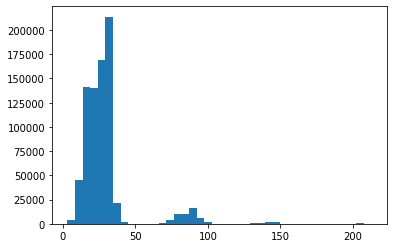

In [32]:
azdias['na_val']= azdias.isnull().sum(axis=1)
plt.hist(azdias.na_val, bins = 40)
azdias


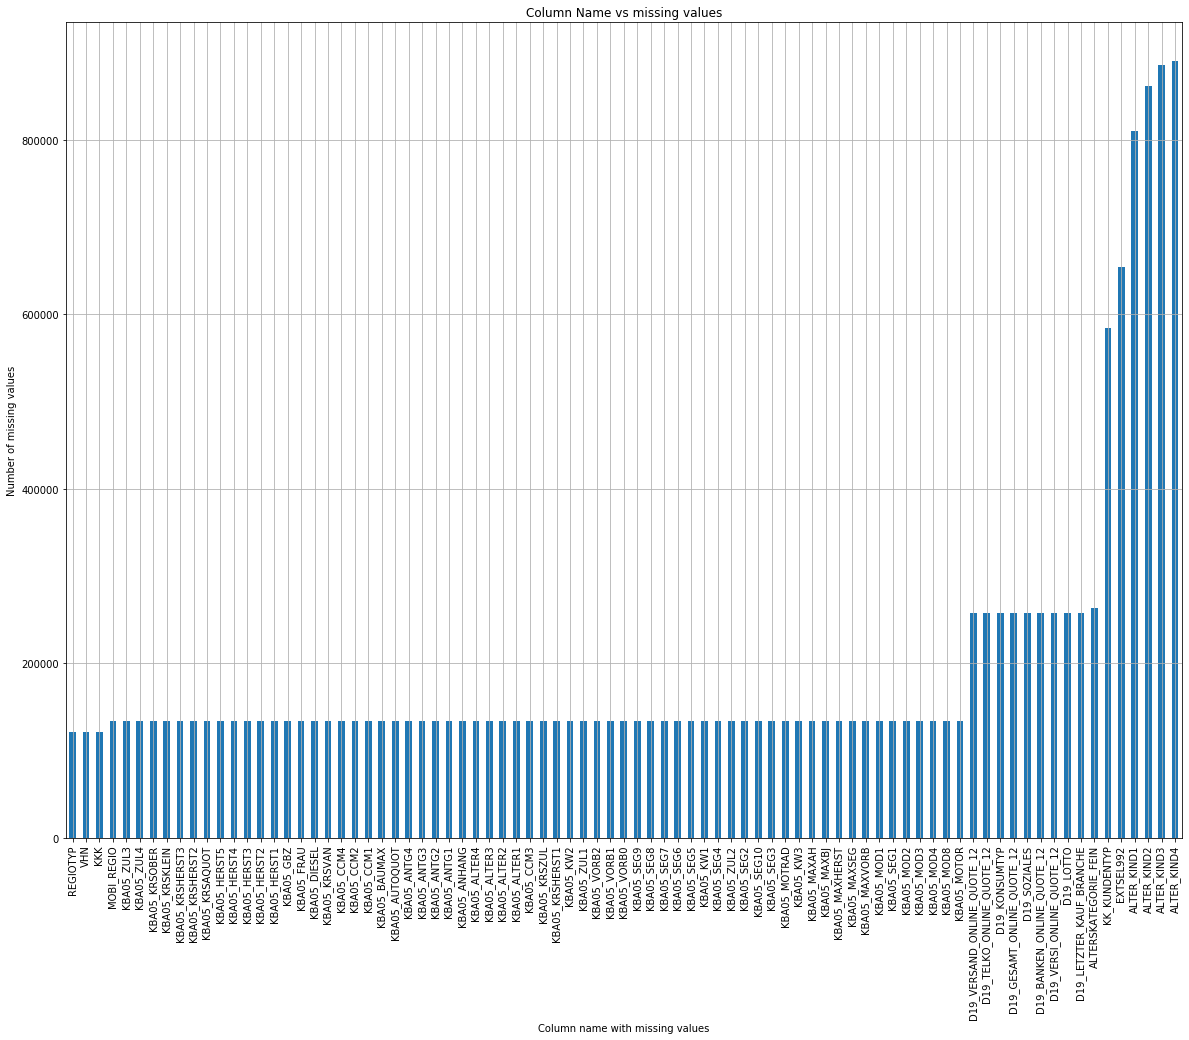

In [87]:
nl_va = azdias.isnull().sum().sort_values()
nl_va = nl_va[nl_va > 120000]
nl_va.plot.bar(figsize= (20, 15))
plt.xlabel('Column name with missing values')
plt.ylabel('Number of missing values')
plt.grid(True)
plt.title('Column Name vs missing values')
plt.show()

Columns with most number of missing values

### Step 1.5: Re-Encode Categorical Features
For categorical data, one would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:

- For binary (two-level) categoricals that take numeric values, one can keep them without needing to do anything.  
 (There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.)
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis.

In [29]:
categorical_binary=[]
for feature in azdias.columns:
    if azdias[feature].nunique() == 2:
        categorical_binary.append(feature)
        
categorical_binary

['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'ANREDE_KZ']

The binary variables are 'GREEN_AVANTGARDE', 'OST_WEST_KZ' and 'ANREDE_KZ'

  
        
    The column 'OST_WEST_KZ' does not contain numerical values instead it contains values 'W' and 'O' which can be encoded  to 1 and 0 respectively

In [30]:
try:
    azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
except:pass


Categorical Variable Columns which have larger number of Attribute values are to be dropped from the data

In [37]:
cls = list(set(azdias.columns.values).intersection(set(attr_vals['Attribute'])))
attr_vals[['Attribute', 'Value']].groupby('Attribute').count().loc[cls].sort_values('Value', ascending = False).head(20)


,Value
Attribute,
CAMEO_DEU_2015,44
LP_LEBENSPHASE_FEIN,40
ALTER_HH,22
PRAEGENDE_JUGENDJAHRE,16
LP_LEBENSPHASE_GROB,12
GFK_URLAUBERTYP,12
LP_FAMILIE_GROB,11
D19_VERSAND_ONLINE_QUOTE_12,11
D19_BANKEN_ONLINE_QUOTE_12,11


In [38]:
drp = attr_vals[['Attribute', 'Value']].groupby(
    'Attribute').count().loc[cls].sort_values(
    'Value', ascending = False).head(3).index.values
azdias.drop(drp, axis= 1, inplace= True)


In [39]:
tp = attr_vals.loc[attr_vals['Attribute'].isin(list(azdias.columns.values))]
pd.set_option('display.max_rows', None)
tp
# .T[az3.columns.values]

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,best-ager typology,0,no classification possible
3,AGER_TYP,best-ager typology,1,passive elderly
4,AGER_TYP,best-ager typology,2,cultural elderly
5,AGER_TYP,best-ager typology,3,experience-driven elderly
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
10,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


#### Finding out the Categorical Columns

In [40]:
tp[tp['Meaning'].str.contains('low', regex=True, na=False)]
a = (set(tp[tp['Meaning'].str.contains('0|1|2|3|4|5|6|7|8|9|low|some|small|numeric|very', regex=True, na=False)]['Attribute']))
b = list((set(tp['Attribute'])).difference(a))
cat_cols = list(set(tp.loc[tp['Attribute'].isin(b)]['Attribute']))
set(cat_cols)

{'AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'D19_KONSUMTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'KBA05_MAXHERST',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'RETOURTYP_BK_S',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP'}

Check whether all categorical columns are present in the data or not

In [41]:
set(azdias.columns[azdias.columns.isin(cat_cols)])

{'AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'D19_KONSUMTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'KBA05_MAXHERST',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'RETOURTYP_BK_S',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP'}

####  Performing one hot encoding: Dummying all Categorical columns and then dropping previous column

In [42]:
for col in cat_cols:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print("Dropping the dummied columns")
azdias.drop(cat_cols, axis=1, inplace = True)


Dropping the dummied columns


Check  shape of Dataframe now

In [90]:
azdias.shape

(891221, 366)

 ### 1.6: Assess Missing Data in Each Row¶
Looking at "Histogram of missing value counts" in rows we can see that most rows at least some amount of  missing values  
To deal with them either of the following options must be opted:
  
  
1. Dropping all the missing values. The problem with this method is that we loss almost 80% of the data since the missing values are spread across all rows and columns and we would end up with about 92000 rows which I believe is too little data compared to the original data size.
  
  
2. Filling the missing values with the mode or the most frequent value of each column. This way we won't miss too many data.  
     
     
I decide to go for the latter method since I do not want to miss too much data.



In [45]:
columns = azdias.columns[azdias.isnull().any()]
for col in columns:
    most_freq = azdias.groupby([col])[col].count().sort_values(ascending=False).index[0]
    azdias[col].fillna(most_freq, inplace=True)


Since all the NaN values have been imputed, the 'na_val'column can now be dropped

In [47]:
azdias.drop('na_val',axis=1, inplace= True)

In [48]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
1,11.0,0.0,2.0,0.0,6.0,8.0,1.0,1.0,9.0,8.0,...,1,0,0,0,0,0,0,0,0,1
2,10.0,0.0,1.0,0.0,2.0,4.0,1.0,1.0,9.0,8.0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,4.0,2.0,1.0,1.0,9.0,8.0,...,0,0,0,1,0,0,0,0,0,0
4,3.0,0.0,4.0,0.0,2.0,6.0,3.0,5.0,5.0,8.0,...,0,0,1,1,0,0,0,0,0,0
5,5.0,0.0,1.0,0.0,6.0,8.0,1.0,1.0,9.0,8.0,...,0,0,0,1,0,0,0,0,0,0


## Step 1.7 Creating Cleaning Function
A function is to be created to clean any data in the same manner as the above Azdias data has been

In [185]:
def clean_data(customers, unsupervised= True, rows= True):
    print('Correcting invalid values with NaN')
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    try:
        customers[cols] = customers[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
        print('Converting nessecary columns to float type')
        customers[cols] = customers[cols].astype(float)
    except: pass
    
    if unsupervised:
        print('Deleting 1st set of unnessecary columns')
        customers.drop(dif, axis = 1, inplace = True)
    
    try:
        print('Deleting Customer info columns')
        customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace = True)
    except: pass
    
    print('Changing Binary Categorical Column data to number type')
    customers['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    
    p=0
    print('Setting NaN values for Na Columns')
    for col,val in zip(na_val.index, na_val.values):
        if(col in customers.columns):
            customers.loc[customers[col].isin(val),col]= np.nan
            p+=1
            print(p, 'of ',250, 'done!')

    customers['na_val']= customers.isnull().sum(axis=1)
    if rows:
        customers.drop(customers.loc[customers['na_val']>150].index, inplace = True)
        print('Removing Rows with large amount of missing Values')
#     customers = customers.drop(del_col, axis = 1)
    if unsupervised:
        customers.drop(drp, axis= 1, inplace= True)
        display(customers.shape)
  
    if unsupervised == False:
        tp = attr_vals.loc[attr_vals['Attribute'].isin(list(azdias.columns.values))]
        a = (set(tp[tp['Meaning'].str.contains('0|1|2|3|4|5|6|7|8|9|low|some|small|numeric|very', regex=True, na=False)]['Attribute']))
        b = list((set(tp['Attribute'])).difference(a))
        cat_cols = list(set(tp.loc[tp['Attribute'].isin(b)]['Attribute']))

    print('Getting Dummies of Categorical columns')
    for col in cat_cols:
        dummy = pd.get_dummies(customers[col], prefix = col)
        customers = pd.concat([customers, dummy], axis = 1)
    
    print("Dropping the dummied columns")
    customers.drop(cat_cols, axis=1, inplace = True)
    
    print('Filling Null Values')
    columns = customers.columns[customers.isnull().any()]
    for col in columns:
        most_freq = customers.groupby([col])[col].count().sort_values(ascending=False).index[0]
        customers[col].fillna(most_freq, inplace=True)

#     customers = customers.fillna(0)
    customers.drop('na_val', axis= 1, inplace= True)
    return customers

## It's now time to bring in the demographics data of the existing customers

In [49]:
#Load Customers Data
customers = pd.read_csv('./Customers.csv').drop(['Unnamed: 0'], axis=1)

E:\Program_Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Analysing the Customers dataset

In [50]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [51]:
customers.shape

(191652, 369)

In [52]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [53]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [54]:
customers.duplicated().sum()

0

## Clean the Customers data in the same manner as the Azdias data

In [56]:
customers= clean_data(customers)

Correcting invalid values with NaN
Converting nessecary columns to float type
Deleting 1st set of unnessecary columns
Deleting Customer info columns
Changing Binary Categorical Column data to number type
Setting NaN values for Na Columns
1 of  250 done!
2 of  250 done!
3 of  250 done!
4 of  250 done!
5 of  250 done!
6 of  250 done!
7 of  250 done!
8 of  250 done!
9 of  250 done!
10 of  250 done!
11 of  250 done!
12 of  250 done!
13 of  250 done!
14 of  250 done!
15 of  250 done!
16 of  250 done!
17 of  250 done!
18 of  250 done!
19 of  250 done!
20 of  250 done!
21 of  250 done!
22 of  250 done!
23 of  250 done!
24 of  250 done!
25 of  250 done!
26 of  250 done!
27 of  250 done!
28 of  250 done!
29 of  250 done!
30 of  250 done!
31 of  250 done!
32 of  250 done!
33 of  250 done!
34 of  250 done!
35 of  250 done!
36 of  250 done!
37 of  250 done!
38 of  250 done!
39 of  250 done!
40 of  250 done!
41 of  250 done!
42 of  250 done!
43 of  250 done!
44 of  250 done!
45 of  250 done!
46 of 

(140863, 270)

Getting Dummies of Categorical columns
Dropping the dummied columns
Filling Null Values


Drop the columns from the Azdias data which are not present in the customers data

In [57]:
azdias.drop(set(azdias.columns.values).difference(set(customers.columns.values)), axis = 1, inplace= True)

## Step 2: Feature Transformation  
  
    
### Step 2.1: Apply Feature Scaling
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.  



The StandardScaler is chosen to scale all values of the data

In [58]:
scaler = StandardScaler()


In [59]:
#Scaling down values in AZDIAS data
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)
azdias.head(10)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
0,0.170599,-0.125322,0.233024,-0.060662,0.846075,0.980901,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,5.306605,-0.257594,-0.556464,-1.163958,-0.078333,-0.537946,-0.03356,-0.027945,2.049950
1,0.106802,-0.125322,-0.630522,-0.060662,-0.985283,-0.625455,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817
2,-0.467367,-0.125322,-1.494067,-0.060662,-0.069604,-1.428633,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817
3,-0.339774,-0.125322,1.960115,-0.060662,-0.985283,0.177723,5.355761,7.260503,-2.315562,0.074433,...,-0.374769,-0.188444,-0.257594,1.797063,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817
4,-0.212181,-0.125322,-0.630522,-0.060662,0.846075,0.980901,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817
5,-0.275977,-0.125322,-0.630522,-0.060662,0.846075,-0.625455,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817
6,-0.148384,-0.125322,-0.630522,-0.060662,-0.985283,-1.428633,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,-1.163958,-0.078333,-0.537946,-0.03356,-0.027945,2.049950
7,-0.403571,2.958604,-0.630522,-0.060662,-0.527444,-1.830222,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,-1.163958,-0.078333,1.858924,-0.03356,-0.027945,-0.487817
8,0.043006,-0.125322,-0.630522,-0.060662,0.846075,-1.830222,-0.166694,-0.225194,-0.309763,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,-1.163958,-0.078333,1.858924,-0.03356,-0.027945,-0.487817
9,-0.148384,-0.125322,-0.630522,-0.060662,0.846075,1.382491,-0.166694,-0.225194,0.358836,0.074433,...,-0.374769,-0.188444,-0.257594,-0.556464,0.859137,-0.078333,-0.537946,-0.03356,-0.027945,-0.487817


In [60]:
#Scaling down values in Customers data
customers = pd.DataFrame(scaler.fit_transform(customers), columns = customers.columns)
customers.head(10)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
0,-0.276249,-0.122476,-0.195727,-0.133735,-0.615645,-1.406064,-0.147536,-0.200505,0.368490,-0.140980,...,2.047567,-0.102974,-0.243310,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989
1,-0.276249,-0.122476,-0.913749,-0.133735,1.276197,0.277965,-0.147536,-0.200505,0.368490,-0.140980,...,-0.488384,-0.102974,-0.243310,-0.821503,-1.427792,-0.120891,-0.447463,-0.042166,-0.031541,2.427249
2,-0.345995,-0.122476,-1.631772,-0.133735,1.276197,-0.143043,-0.147536,-0.200505,0.368490,-0.140980,...,-0.488384,-0.102974,-0.243310,-0.821503,-1.427792,8.271931,-0.447463,-0.042166,-0.031541,-0.411989
3,0.142231,-0.122476,1.240319,-0.133735,-0.615645,1.119979,-0.147536,2.108124,-3.526549,-0.140980,...,-0.488384,-0.102974,-0.243310,1.217281,-1.427792,-0.120891,2.234821,-0.042166,-0.031541,-0.411989
4,-0.276249,-0.122476,-0.195727,-0.133735,1.276197,0.277965,-0.147536,-0.200505,0.368490,-0.140980,...,2.047567,-0.102974,-0.243310,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989
5,-0.276249,-0.122476,-0.195727,-0.133735,0.803237,-0.564050,-0.147536,-0.200505,0.368490,-0.140980,...,2.047567,-0.102974,-0.243310,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989
6,-0.276249,-0.122476,-0.195727,-0.133735,0.330276,-1.406064,-0.147536,-0.200505,0.368490,-0.140980,...,2.047567,-0.102974,-0.243310,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989
7,4.815254,3.565112,-0.913749,-0.133735,-0.615645,1.961993,-0.147536,-0.200505,0.368490,-0.140980,...,-0.488384,-0.102974,-0.243310,-0.821503,-1.427792,-0.120891,2.234821,-0.042166,-0.031541,-0.411989
8,-0.276249,-0.122476,0.522296,-0.133735,-1.088605,-1.406064,-0.147536,-0.200505,-0.280683,5.123363,...,-0.488384,-0.102974,4.109977,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989
9,-0.276249,-0.122476,-0.913749,-0.133735,0.803237,-0.985057,-0.147536,-0.200505,0.368490,-0.140980,...,-0.488384,-0.102974,-0.243310,-0.821503,0.700382,-0.120891,-0.447463,-0.042166,-0.031541,-0.411989


## Step 2.2: Perform Dimensionality Reduction
On our scaled data, we are now ready to apply dimensionality reduction techniques.

Sklearn\'s PCA class is uto be used to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
In the beginning, no parameters are set (so all components are computed)  
By checking out the ratio of variance explained by each principal component as well as the cumulative variance explained, the number of components is to be reduced.  
Post reducing the components, PCA is to be re-fit.

In [95]:
pca = PCA()
az_pca = pca.fit_transform(azdias)


ValueError: could not convert string to float: '8A'

Text(0.5, 1.0, 'Variance Explained Per Principal Component')

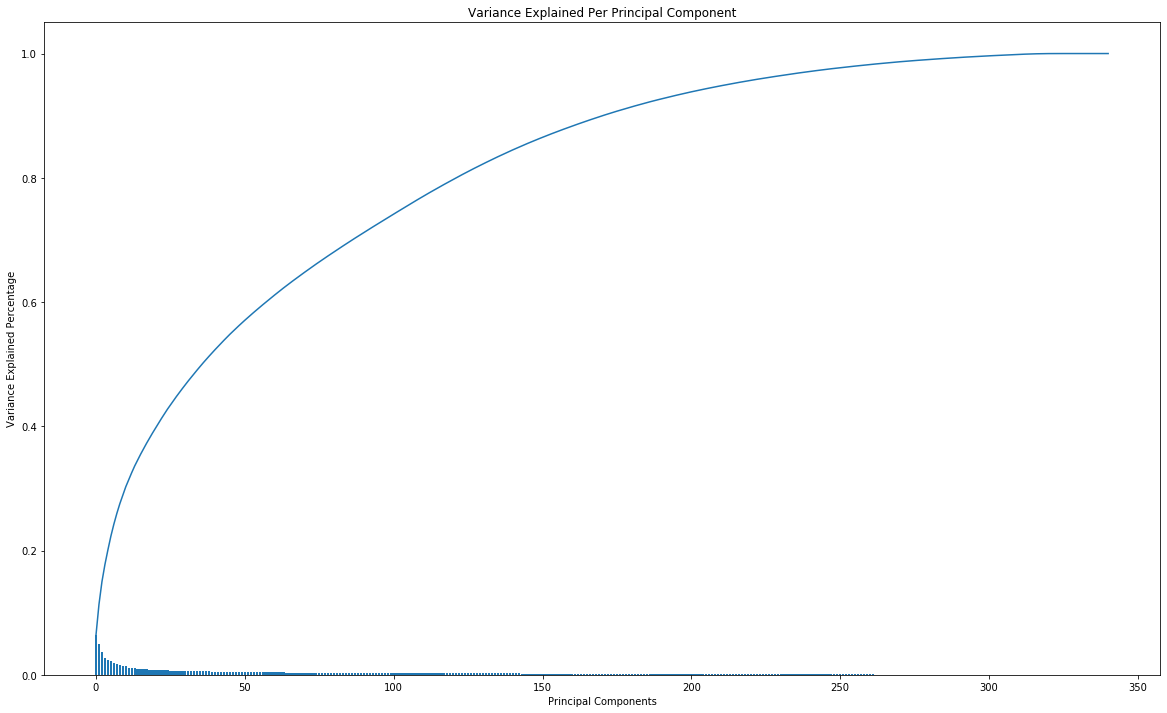

In [63]:
num_components = len(pca.explained_variance_ratio_)
indx = np.arange(num_components)
valu = pca.explained_variance_ratio_

plt.figure(figsize=(20,12))
ax = plt.subplot()
cumvalu = np.cumsum(valu)
ax.bar(indx, valu)
ax.plot(indx, cumvalu)

ax.set_xlabel("Principal Components")
ax.set_ylabel("Variance Explained Percentage")
plt.title('Variance Explained Per Principal Component')



In [94]:
n_components = (np.where(np.cumsum(pca.explained_variance_ratio_)>0.85)[0]+1)[0] # 80% of variance selected

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'green');
ax.set_title('n_components needed for variance > 80%: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=7);


AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [66]:
pca = PCA(n_components = 120)
az_pca = pca.fit_transform(azdias)
cu_pca = pca.fit_transform(customers)
pca.explained_variance_ratio_

KeyboardInterrupt: 

Post applying PCA, we check the contribution of different features in the top 3 components.

In [ ]:
def pca_results(pca, comp):
    
    feature = azdias.columns.tolist()
    component = pca.components_[comp].tolist()
    feature_weight = pd.DataFrame(list(zip(feature, component)))
    feature_weight.set_axis(['Feature', 'Weight'], axis=1, inplace=True)
    feature_weight = feature_weight.sort_values(by=['Weight'] , ascending=False)
    
    return feature_weight

first_component = pca_results(pca, 1)
print(first_component.head())
print(first_component.tail())


In [ ]:


second_component = pca_results(pca, 2)
print(second_component.head())
print(second_component.tail())


In [ ]:
third_component = pca_results(pca, 3)
print(third_component.head())
print(third_component.tail())


## Step 3: Clustering
### Step 3.1: Apply Clustering to General Population¶
We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [ ]:
# Kmean Scores are calculated iteratively till 30, skipping every other number to visualize the trend of scores
kmeans_scores = []
for i in range(1,30, 2):
    print('Beginning ',i)
    #run k-means clustering on the data 
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(az_pca)
    
    #compute the average within-cluster distances.
    #print(i,kmeans.score(azdias_pca))
    kmeans_scores.append(np.abs(kmeans.score(az_pca)))
    print(i, ' Done')


In [ ]:
kmeans_scores

In [ ]:
#Plotting KMeanScores to see elbow plot
x = range(1, 30, 2)
plt.figure(figsize=(16, 8))
plt.plot(x, kmeans_scores, marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances');


Choosing Value of K as per above elbow plot

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data and customers data

kmeans = KMeans(n_clusters= 7, random_state=42)
customers_predictions = kmeans.fit_predict(cu_pca)
azdias_predictions = kmeans.predict(az_pca)



In [ ]:
#Checking clusters of first 20 customers
customers_predictions[:20]


In [ ]:
Checking distribution of Customers and General population across clusters
customer_clusters = pd.Series(customers_predictions)
cc = customer_clusters.value_counts().sort_index()

population_clusters = pd.Series(azdias_predictions)
pc = population_clusters.value_counts().sort_index()

df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

total_customer = sum(df_stat.customer.values)
total_population = sum(df_stat.population.values)

df_stat['population'] = (df_stat['population']/total_population)*100
df_stat['customer'] = (df_stat['customer']/total_customer)*100
df_stat['difference'] = (df_stat['customer']-df_stat['population'])

df_stat

In [ ]:
b= []
for i in range(1, 30):
    kmeans = KMeans(n_clusters= i, random_state=42)
    customers_predictions = kmeans.fit_predict(cu_pca)
    # clusters_pop = kmeans.fit_predict(az_pca)
    azdias_predictions = kmeans.predict(az_pca)

    customer_clusters = pd.Series(customers_predictions)
    cc = customer_clusters.value_counts().sort_index()

    population_clusters = pd.Series(azdias_predictions)
    pc = population_clusters.value_counts().sort_index()

    df_stat = pd.concat([pc, cc], axis=1).reset_index()
    df_stat.columns = ['cluster','population','customer']

    total_customer = sum(df_stat.customer.values)
    total_population = sum(df_stat.population.values)

    df_stat['population'] = (df_stat['population']/total_population)*100
    df_stat['customer'] = (df_stat['customer']/total_customer)*100
    df_stat['difference'] = (df_stat['customer']-df_stat['population'])

    a = df_stat.sort_values('difference', ascending = False)['difference'].head(1)

    b.append([i, a.index.values[0], a.values[0]])
    print(i)
print(b)

In [ ]:
mx=0
for i in range(3,30):
    if b[i][2] >mx :
        mx= b[i][2]
mx

In [ ]:
feat_descs = attr_vals[["Attribute", "Description"]].copy().set_index("Attribute")

dimensions = ["Dimension {}".format(i) for i in range(1, len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns=customers.columns)
components.index = dimensions

ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=["Explained Variance"])
variance_ratios.index = dimensions

comp_attr = pd.concat([variance_ratios, components], axis=1)

In [ ]:
#Plotting Distribution of population and Customers across Clusters to see which clusters are fvoured by customers 
customers_prop = []
gen_prop = []
x = [i+1 for i in range(7)]
for i in range(7):
    #general_prop.append((clusters_pop == i).sum()/len(clusters_pop))
    gen_prop.append((azdias_predictions == i).sum()/len(azdias_predictions))
    customers_prop.append((customers_predictions == i).sum()/len(customers_predictions))


df_general = pd.DataFrame({'cluster' : x, 'Customers pop':customers_prop, 'Gen pop': gen_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['Customers pop', 'Gen pop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


In [ ]:
#Obtain attributes for Clusters were Customers are overrepresented
def get_cluster_attributes(kmeans, comp_attr, feat_descs, cluster_number):
    weights = kmeans.cluster_centers_[cluster_number]
    components = list(range(len(weights)))
    
    klusters = pd.DataFrame(columns=["Weight", "Component"])
    klusters["Weight"] = weights
    klusters["Component"] = components
    klusters = klusters.sort_values("Weight", ascending=False)

    # consider only 2 components per cluster
    klusters = klusters.head(2)

    clus_attr = pd.DataFrame()
    for item in klusters["Component"]:

        tds = comp_attr.loc["Dimension " + str(item+1)].sort_values()
        # consider only 3 attributes per component
        tds = tds.iloc[:3].append(tds.iloc[-3:])

        bf = pd.DataFrame(columns=["Component", "Attribute", "Values"])
        bf["Component"] = [item] * len(tds.index)
        bf["Attribute"] = tds.index
        bf["Values"] = tds[tds.index].values

        bf = klusters[klusters["Component"] == item].merge(bf, left_on="Component", right_on="Component")
        clus_attr = clus_attr.append(bf).reset_index(drop=True)
    
    clus_attr = clus_attr.merge(feat_descs, left_on="Attribute", right_index=True)
    
    return clus_attr

cluster_number = 5
clus_attr = get_cluster_attributes(kmeans, comp_attr, feat_descs, cluster_number)
print("Cluster : {}".format(cluster_number))
display(clus_attr.drop_duplicates())




In [ ]:
azdias_clean, customers_clean = azdias.copy(), customers.copy()
azdias_clean['Cluster'] = azdias_predictions
customers_clean['Cluster'] = customers_predictions


def describe_cluster(df1,df2,c):
    """
    plots two countplots of the two dataframes of a random column
    INPUT: two dataframes with high and low NaN proportion
           col string
    """
    df1_T = df1[df1['Cluster']==c].describe().T.sort_values(by='50%',ascending=False)['50%']
    df2_T = df2[df2['Cluster']==c].describe().T.sort_values(by='50%',ascending=False)['50%']
    df_concat = pd.concat([df1_T,df2_T],axis=1).dropna()
    df_concat.columns = ['general_median', 'customer_median']
    df_concat['difference'] = np.abs(df_concat.general_median - df_concat.customer_median)
    df_concat = df_concat.sort_values(by='difference', ascending=False)
    return df_concat.head(10)
describe_cluster(azdias_clean,customers_clean,5)


In [ ]:
2+2

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [120]:
mailout_train = pd.read_csv('Mailout Train.csv')
del mailout_train['Unnamed: 0']

E:\Program_Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [122]:
# mailout_LNR = mailout_train['LNR'] 
# mailout_train.drop('LNR', axis= 1, inplace= True)
mailout_train.shape

(42962, 367)

In [123]:
mailout_train.RESPONSE.value_counts(dropna=False)


0    42430
1      532
Name: RESPONSE, dtype: int64

In [124]:
training_mailout = clean_data(mailout_train, unsupervised= False)


Correcting invalid values with NaN
Converting nessecary columns to float type
Deleting 1st set of unnessecary columns
Deleting Customer info columns
Changing Binary Categorical Column data to number type
Setting NaN values for Na Columns
1 of  250 done!
2 of  250 done!
3 of  250 done!
4 of  250 done!
5 of  250 done!
6 of  250 done!
7 of  250 done!
8 of  250 done!
9 of  250 done!
10 of  250 done!
11 of  250 done!
12 of  250 done!
13 of  250 done!
14 of  250 done!
15 of  250 done!
16 of  250 done!
17 of  250 done!
18 of  250 done!
19 of  250 done!
20 of  250 done!
21 of  250 done!
22 of  250 done!
23 of  250 done!
24 of  250 done!
25 of  250 done!
26 of  250 done!
27 of  250 done!
28 of  250 done!
29 of  250 done!
30 of  250 done!
31 of  250 done!
32 of  250 done!
33 of  250 done!
34 of  250 done!
35 of  250 done!
36 of  250 done!
37 of  250 done!
38 of  250 done!
39 of  250 done!
40 of  250 done!
41 of  250 done!
42 of  250 done!
43 of  250 done!
44 of  250 done!
45 of  250 done!
46 of 

(35093, 271)

Getting Dummies of Categorical columns
Dropping the dummied columns
Filling Null Values


In [125]:
training_mailout.RESPONSE.value_counts(dropna=False)

0    34657
1      436
Name: RESPONSE, dtype: int64

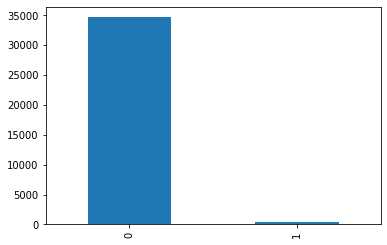

In [126]:
training_mailout.RESPONSE.value_counts(dropna=False).plot.bar()

In [127]:
training_mailout.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
0,15.0,0.0,1.0,0.0,5.0,5.0,1.0,1.0,9.0,5.0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,0.0,2.0,0.0,5.0,5.0,1.0,1.0,5.0,5.0,...,1,0,0,0,1,0,0,0,0,0
2,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,7.0,5.0,...,0,0,0,0,0,1,0,0,0,0
3,4.0,0.0,2.0,0.0,2.0,2.0,1.0,1.0,9.0,5.0,...,1,0,0,0,1,0,0,0,0,0
4,53.0,0.0,1.0,0.0,4.0,7.0,1.0,1.0,9.0,5.0,...,0,0,0,0,0,0,1,0,0,0


In [129]:
training_mailout.isnull().sum().sum()

0

In [130]:
y = training_mailout['RESPONSE']
X = training_mailout.drop('RESPONSE', axis = 1)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [106]:
# mailout_LNR = training_mailout['LNR'] 
# training_mailout.drop('LNR', axis= 1, inplace= True)


In [107]:
mailout_train_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [108]:
mailout_train_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
0,0.546975,-0.129274,-0.749865,-0.091761,0.337655,0.013773,-0.14868,-0.203694,0.358597,-0.121975,...,-0.487518,-0.093013,-0.169137,-0.743636,-1.311796,-0.112032,2.052715,-0.041728,-0.03068,-0.437505
1,-0.376191,-0.129274,-0.014952,-0.091761,0.337655,0.013773,-0.14868,-0.203694,-2.406105,-0.121975,...,2.051207,-0.093013,-0.169137,-0.743636,0.762314,-0.112032,-0.487160,-0.041728,-0.03068,-0.437505
2,-0.442131,-0.129274,-1.484777,-0.091761,-1.484827,-1.227642,-0.14868,-0.203694,-1.023754,-0.121975,...,-0.487518,-0.093013,-0.169137,-0.743636,-1.311796,8.926005,-0.487160,-0.041728,-0.03068,-0.437505
3,-0.178370,-0.129274,-0.014952,-0.091761,-1.029207,-1.227642,-0.14868,-0.203694,0.358597,-0.121975,...,2.051207,-0.093013,-0.169137,-0.743636,0.762314,-0.112032,-0.487160,-0.041728,-0.03068,-0.437505
4,3.052710,-0.129274,-0.749865,-0.091761,-0.117966,0.841383,-0.14868,-0.203694,0.358597,-0.121975,...,-0.487518,-0.093013,-0.169137,-0.743636,-1.311796,-0.112032,2.052715,-0.041728,-0.03068,-0.437505


In [109]:
# y = mailout_train_scaled['RESPONSE']
# X = mailout_train_scaled.drop('RESPONSE', axis= 1)
# y.head()

In [131]:
X.shape

(35093, 341)

In [ ]:
!pip install xgboost

In [111]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn import metrics


In [112]:
clf_A = AdaBoostRegressor(random_state=42)
clf_B = RandomForestRegressor(random_state=42)
clf_C = XGBRegressor(random_state=42)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [145]:
model= AdaBoostRegressor()
# model.fit(X_train, y_train).predict_proba(X_test)
model.fit(X_train, y_train).predict_proba(X_test)

AttributeError: 'AdaBoostRegressor' object has no attribute 'predict_proba'

In [133]:
def modeling_validation(model,X_train, X_test, y_train, y_test):
    
    
    scores = []
    j = 0
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    scores.append(score)

    return scores

In [134]:
models_scores = {}
for clf in [clf_A,clf_B,clf_C]:
    models_scores[clf] = modeling_validation(clf,X_train, X_test, y_train, y_test)


In [135]:
scores = pd.DataFrame(models_scores)
scores.columns = ['AdaBoostRegressor', 'RandomForestRegressor', 'XGBRegressor']
scores

,AdaBoostRegressor,RandomForestRegressor,XGBRegressor
0,0.56964,0.576211,0.518855


In [117]:
def cross_validate(alg, X_train, y_train,
             cv_folds=5, early_stopping_rounds=50):
    

        xgb_param = alg.get_xgb_params()
        xgb_train = xgb.DMatrix(X_train, label=y_train)
        
        cv_result = xgb.cv(xgb_param, xgb_train,
                          num_boost_round=alg.get_params()[
                              'n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=20,
                          early_stopping_rounds=early_stopping_rounds,
                          shuffle=True)
        
        alg.set_params(n_estimators=cv_result.shape[0])
        
        print('n_estimators=', cv_result.shape[0])
        
    # cross-validation
        all_auc = cross_val_score(alg, X_train, y_train,
                              scoring='roc_auc', cv=5,
                              n_jobs=2, verbose=5
                             )
    
        auc = np.average(all_auc)
        print("AUC Score :{} ".format(auc))

In [ ]:
clf_0 = XGBRegressor(
    objective = 'binary:logistic',
    scale_pos_weight = 1, 
    random_state = 42)

In [ ]:
cross_validate(clf_0,X_train, y_train)


In [ ]:
clf_0


In [ ]:
parameters_1 = {
    'clf_max_depth':range(3,10,2),
    'clf_min_child_weight':range(1,6,2)
}

cv = GridSearchCV(estimator = XGBRegressor( n_estimators=100), param_grid = parameters_1, scoring='roc_auc', n_jobs=-1,
                                           iid=False, cv=5, verbose=10 )
cv.fit(X_train,y_train)


In [ ]:
cv.best_score_, cv.best_params_


In [ ]:
clf_1 = XGBRegressor(
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [152]:
reg = lgb.LGBMRegressor(
            learning_rate=0.001, 
            n_estimators=6000,
            lambda_l2 = 0.1
        )
from sklearn.model_selection import GridSearchCV
clf = lgb.LGBMRegressor(random_state=0)
parameters = {'learning_rate' : [0.01, 0.001],
              'max_depth': [3, 5, 10],
              'n_estimators' : [100, 500, 2000]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("ROC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print("\n------")
print(grid_fit.best_params_)


Unoptimized model
------
ROC score on testing data: 0.6046

Optimized Model
------
ROC score on testing data: 0.6240

------
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [151]:
clf = lgb.LGBMRegressor(random_state=0)

predictions = (clf.fit(X_train, y_train)).predict(X_test)
roc_auc_score(y_test, predictions)

0.6045841652164319

In [166]:
best_clf.predict(X_test)[list(best_clf.predict(X_test)>0.03)]

array([0.0301755 , 0.03259737, 0.03144703, 0.03729599, 0.03276203,
       0.03084018, 0.03694769, 0.0339532 , 0.03108299, 0.03151223,
       0.03627397, 0.03226843, 0.0326352 , 0.0303602 , 0.0318685 ,
       0.03783144, 0.032223  , 0.03419846, 0.0326352 , 0.03061638,
       0.03312327, 0.03310376, 0.03079651, 0.04194535])

In [187]:
y_test[list(best_clf.predict(X_test)>0.04)]

30551    0
Name: RESPONSE, dtype: int64

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [179]:
mailout_test = pd.read_csv('Mailout Test.csv')
del mailout_test['Unnamed: 0']

In [186]:
mailout_test = clean_data(mailout_test, unsupervised= False, rows= False)


Correcting invalid values with NaN
Deleting Customer info columns
Changing Binary Categorical Column data to number type


KeyError: 'OST_WEST_KZ'

In [ ]:
best_clf.predict()

In [182]:
test = pd.DataFrame(scaler.fit_transform(mailout_test), columns = mailout_test.columns)
test.shape

ValueError: could not convert string to float: '2B'

In [176]:
mailout_test.shape

(42833, 366)